# Calibrated simulations with THEOP data

Updated: April 23, 2025

This notebook runs simulations using calibrated data from the Texas Higher Education Opportunity Project (THEOP).

The notebook:
1. Loads and preprocesses THEOP student data from 1992-1997
2. Calibrates simulation parameters using the historical data
3. Runs multiple simulations with different cost and barrier parameters
4. Evaluates how the models impact fairness and efficiency metrics
5. Visualizes results across different demographic groups and parameter settings



In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import os

import seaborn as sns


from collections import defaultdict
import re
import ast  # Required to convert string representation of list to list
import itertools

from sklearn.linear_model import LinearRegression


from ipywidgets import IntProgress
from IPython.display import display

In [2]:
import save_results
#import pipeline_run_parallel
from visualization.evaluate_param_changes import plot_group_features_by_param,plot_feature_by_param
import helpers
import pipeline
# from visualization.fancier_plots import *
#from visualization.IndivFairness import *

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


from pipeline_cost_run_multiple_instances import run_cost_model_different_costs, defaultdict_converter, literal_converter


In [3]:
#from generic.latexify import *
from data_processing.theop_loading import load_application_files,process_applications, load_and_process_applications_transcripts


In [97]:
simulation_type = "calibrated_theop_2025_mult_runs"

simulation_data_folder = 'simulation_data_cost_model_vary_costs_by_group/'
simulation_data_path = simulation_data_folder+simulation_type+"/"
simulation_data_info_path = simulation_data_folder+simulation_type+"_info/"
figure_data_folder = 'visualization/plots_may_2025/vary_costs_by_group/'
figure_data_path = figure_data_folder+simulation_type+"/"

if not os.path.exists(simulation_data_path): os.makedirs(simulation_data_path)
if not os.path.exists(figure_data_path): os.makedirs(figure_data_path)
if not os.path.exists(simulation_data_info_path): os.makedirs(simulation_data_info_path)
    

# Read in data

In [5]:
dfa = load_application_files()
dfa = process_applications(dfa)

In [6]:
dfa.head()

,studentid,instcode,institution,yeardes,termdes,male,ethnic,decileR,major_field,hsprivate,hstypeR,hsinstate,hseconstatus,admit,enroll,gradyear,testscore
0,am000001,am,Texas A&M,1992,Fall,Male,International,NaN,ENGINEERING/COMPUTER SCIENCE,NaN,NaN,No,NaN,No,No,NaN,NaN
1,am000002,am,Texas A&M,1992,Fall,Male,International,NaN,NATURAL/PHYSICAL SCIENCES,NaN,NaN,No,NaN,Yes,Yes,1994 or 1995,NaN
2,am000003,am,Texas A&M,1992,Fall,Female,"White, Non-Hispanic",NaN,NATURAL/PHYSICAL SCIENCES,Private,NaN,No,NaN,Yes,Yes,1996,1090.0
3,am000004,am,Texas A&M,1998,Fall,Female,"White, Non-Hispanic",0.8,AGRICULTURE,Public,Regular,Yes,0.50,Yes,No,NaN,1010.0
4,am000005,am,Texas A&M,1998,Fall,Male,"White, Non-Hispanic",0.5,NATURAL/PHYSICAL SCIENCES,Public,Regular,Yes,0.25,No,No,NaN,915.0


In [7]:
dfa.columns

Index(['studentid', 'instcode', 'institution', 'yeardes', 'termdes', 'male',
       'ethnic', 'decileR', 'major_field', 'hsprivate', 'hstypeR', 'hsinstate',
       'hseconstatus', 'admit', 'enroll', 'gradyear', 'testscore'],
      dtype='object')

In [8]:
dfa2002 = dfa.query('yeardes == 2002')

In [9]:
dfa2002.loc[:, 'decilefloat'] = dfa2002.decileR.astype(float)

In [10]:
dfa2002.groupby(['ethnic'])['decilefloat', 'testscore'].describe()

/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_87827/3248800195.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfa2002.groupby(['ethnic'])['decilefloat', 'testscore'].describe()


decilefloat                                     \
                                     count      mean       std  min  25%  50%   
ethnic                                                                          
American Indian/Alaskan Native       138.0  0.728261  0.187954  0.3  0.6  0.8   
Asian or Pacific Islander           5822.0  0.763758  0.177381  0.3  0.7  0.8   
Black, Non-Hispanic                 3273.0  0.668469  0.207549  0.3  0.5  0.7   
Hispanic                           11924.0  0.674765  0.209907  0.3  0.5  0.7   
International                        413.0  0.750847  0.183098  0.3  0.7  0.8   
Other                                672.0  0.720685  0.200381  0.3  0.6  0.8   
White, Non-Hispanic                36289.0  0.722985  0.184663  0.3  0.6  0.8   

                                         testscore                           \
                                75%  max     count         mean         std   
ethnic                                                                        
American Indian/Alaskan Native  0.9  0.9     155.0  1150.838710  148.081694   
Asian or Pacific Islander       0.9  0.9    7060.0  1240.148725  187.871253   
Black, Non-Hispanic             0.9  0.9    3561.0  1015.226060  170.746867   
Hispanic                        0.9  0.9   13916.0   979.977364  191.504739   
International                   0.9  0.9    1830.0  1207.265027  155.012630   
Other                           0.9  0.9    1146.0  1164.576789  236.187457   
White, Non-Hispanic             0.9  0.9   42507.0  1169.859553  164.145144   

                                                                       
                                  min     25%     50%     75%     max  
ethnic                                                                 
American Indian/Alaskan Native  850.0  1055.0  1140.0  1235.0  1540.0  
Asian or Pacific Islander       700.0  1110.0  1250.0  1390.0  1580.0  
Black, Non-Hispanic             700.0   870.0  1000.0  1130.0  1580.0  
Hispanic                        700.0   815.0   965.0  1110.0  1580.0  
International                   850.0  1110.0  1220.0  1320.0  1580.0  
Other                           700.0   990.0  1175.0  1360.0  1580.0  
White, Non-Hispanic             700.0  1055.0  1160.0  1285.0  1580.0

In [11]:
dfa2002.groupby(['male'])['decilefloat', 'testscore'].describe()

/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_87827/1151066989.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfa2002.groupby(['male'])['decilefloat', 'testscore'].describe()


decilefloat                                              testscore  \
             count      mean       std  min  25%  50%  75%  max     count   
male                                                                        
Female     30332.0  0.737894  0.182203  0.3  0.6  0.8  0.9  0.9   36177.0   
Male       28535.0  0.689245  0.200524  0.3  0.5  0.7  0.9  0.9   34804.0   

                                                                        
               mean         std    min     25%     50%     75%     max  
male                                                                    
Female  1110.391962  189.964534  700.0   980.0  1110.0  1240.0  1580.0  
Male    1156.185352  195.916544  700.0  1030.0  1160.0  1300.0  1580.0

In [12]:
dfa2002.groupby(['hseconstatus'])['decilefloat', 'testscore'].describe()

/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_87827/4236698133.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfa2002.groupby(['hseconstatus'])['decilefloat', 'testscore'].describe()


decilefloat                                               \
                   count      mean       std  min  25%  50%  75%  max   
hseconstatus                                                            
0.75             24974.0  0.701129  0.190215  0.3  0.6  0.8  0.9  0.9   
0.5               8481.0  0.754251  0.168830  0.3  0.7  0.8  0.9  0.9   
0.25              5670.0  0.753175  0.183149  0.3  0.7  0.8  0.9  0.9   
0.0               6575.0  0.723954  0.200037  0.3  0.6  0.8  0.9  0.9   

             testscore                                                  \
                 count         mean         std    min     25%     50%   
hseconstatus                                                             
0.75           25815.0  1163.249080  161.700795  700.0  1055.0  1160.0   
0.5             8668.0  1130.364559  168.072437  700.0  1010.0  1120.0   
0.25            5827.0  1059.906470  180.370144  700.0   930.0  1055.0   
0.0             7353.0   936.848905  172.679032  700.0   815.0   915.0   

                              
                 75%     max  
hseconstatus                  
0.75          1270.0  1580.0  
0.5           1245.0  1580.0  
0.25          1180.0  1580.0  
0.0           1055.0  1580.0

In [13]:
dfa.instcode.unique()

array(['am', 'amk', 'ar', 'au', 'pa', 'tt', 'ri', 'sm'], dtype=object)

In [14]:
dfa2002ut = dfa.query('yeardes == 2002 and instcode == "au"')
dfa2002ut.head()

,studentid,instcode,institution,yeardes,termdes,male,ethnic,decileR,major_field,hsprivate,hstypeR,hsinstate,hseconstatus,admit,enroll,gradyear,testscore
34152,au034153,au,UT Austin,2002,Fall,Male,International,NaN,UNDECLARED,NaN,NaN,No,NaN,No,No,NaN,1170.0
34153,au034154,au,UT Austin,2002,Fall,Female,Hispanic,0.9,BUSINESS,Public,Regular,Yes,0.50,Yes,Yes,NaN,1240.0
34154,au034155,au,UT Austin,2002,Fall,Male,"White, Non-Hispanic",NaN,SOCIAL SCIENCES,Private,NaN,Yes,NaN,No,No,NaN,1260.0
34155,au034156,au,UT Austin,2002,Summer I,Female,"White, Non-Hispanic",0.8,UNDECLARED,Public,Regular,Yes,0.50,Yes,No,NaN,1090.0
34156,au034157,au,UT Austin,2002,Summer I,Male,"White, Non-Hispanic",0.8,UNDECLARED,Public,Regular,Yes,0.75,Yes,No,NaN,1390.0


In [15]:

dfa2002ut.loc[:, 'decilefloat'] = dfa2002ut.decileR.astype(float)
dfa2002ut.head()

,studentid,instcode,institution,yeardes,termdes,male,ethnic,decileR,major_field,hsprivate,hstypeR,hsinstate,hseconstatus,admit,enroll,gradyear,testscore,decilefloat
34152,au034153,au,UT Austin,2002,Fall,Male,International,NaN,UNDECLARED,NaN,NaN,No,NaN,No,No,NaN,1170.0,NaN
34153,au034154,au,UT Austin,2002,Fall,Female,Hispanic,0.9,BUSINESS,Public,Regular,Yes,0.50,Yes,Yes,NaN,1240.0,0.9
34154,au034155,au,UT Austin,2002,Fall,Male,"White, Non-Hispanic",NaN,SOCIAL SCIENCES,Private,NaN,Yes,NaN,No,No,NaN,1260.0,NaN
34155,au034156,au,UT Austin,2002,Summer I,Female,"White, Non-Hispanic",0.8,UNDECLARED,Public,Regular,Yes,0.50,Yes,No,NaN,1090.0,0.8
34156,au034157,au,UT Austin,2002,Summer I,Male,"White, Non-Hispanic",0.8,UNDECLARED,Public,Regular,Yes,0.75,Yes,No,NaN,1390.0,0.8


In [16]:
dfa2002ut.groupby(['ethnic'])['decilefloat', 'testscore'].describe()

/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_87827/1749402535.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfa2002ut.groupby(['ethnic'])['decilefloat', 'testscore'].describe()


decilefloat                                     \
                                     count      mean       std  min  25%  50%   
ethnic                                                                          
American Indian/Alaskan Native        72.0  0.750000  0.174421  0.3  0.6  0.8   
Asian or Pacific Islander           2481.0  0.790367  0.152717  0.3  0.7  0.9   
Black, Non-Hispanic                  761.0  0.742838  0.178013  0.3  0.7  0.8   
Hispanic                            2579.0  0.777239  0.160142  0.3  0.7  0.8   
International                        246.0  0.738211  0.188450  0.3  0.6  0.8   
White, Non-Hispanic                 9158.0  0.770780  0.153799  0.3  0.7  0.8   

                                         testscore                           \
                                75%  max     count         mean         std   
ethnic                                                                        
American Indian/Alaskan Native  0.9  0.9      86.0  1177.325581  140.726472   
Asian or Pacific Islander       0.9  0.9    2853.0  1239.348055  166.269857   
Black, Non-Hispanic             0.9  0.9     809.0  1062.373300  149.883178   
Hispanic                        0.9  0.9    2776.0  1093.654539  154.276574   
International                   0.9  0.9    1222.0  1195.319149  148.897327   
White, Non-Hispanic             0.9  0.9   10677.0  1215.546034  143.589008   

                                                                       
                                  min     25%     50%     75%     max  
ethnic                                                                 
American Indian/Alaskan Native  870.0  1075.0  1175.0  1270.0  1540.0  
Asian or Pacific Islander       850.0  1120.0  1240.0  1360.0  1580.0  
Black, Non-Hispanic             850.0   950.0  1055.0  1180.0  1580.0  
Hispanic                        850.0   980.0  1090.0  1200.0  1580.0  
International                   850.0  1100.0  1210.0  1290.0  1580.0  
White, Non-Hispanic             850.0  1120.0  1220.0  1310.0  1580.0

In [17]:
dfa2002ut.groupby(['hseconstatus'])['decilefloat', 'testscore'].describe()

/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_87827/1719301669.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfa2002ut.groupby(['hseconstatus'])['decilefloat', 'testscore'].describe()


decilefloat                                               \
                   count      mean       std  min  25%  50%  75%  max   
hseconstatus                                                            
0.75              7536.0  0.757378  0.160254  0.3  0.7  0.8  0.9  0.9   
0.5               2646.0  0.791194  0.141080  0.3  0.7  0.8  0.9  0.9   
0.25              1315.0  0.831939  0.116123  0.3  0.8  0.9  0.9  0.9   
0.0               1327.0  0.843331  0.107902  0.3  0.8  0.9  0.9  0.9   

             testscore                                                  \
                 count         mean         std    min     25%     50%   
hseconstatus                                                             
0.75            7778.0  1216.902160  148.451929  850.0  1110.0  1220.0   
0.5             2652.0  1178.065611  153.808408  850.0  1070.0  1180.0   
0.25            1317.0  1126.469248  156.369652  850.0  1010.0  1120.0   
0.0             1335.0  1036.314607  150.242852  850.0   915.0  1010.0   

                              
                 75%     max  
hseconstatus                  
0.75          1320.0  1580.0  
0.5           1280.0  1580.0  
0.25          1230.0  1580.0  
0.0           1140.0  1580.0

In [18]:
dfa2002ut.groupby(['male'])['decilefloat', 'testscore'].describe()

/var/folders/nh/c5btrdls7t165h7hmmljwqj80000gq/T/ipykernel_87827/2068720500.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfa2002ut.groupby(['male'])['decilefloat', 'testscore'].describe()


decilefloat                                              testscore  \
             count      mean       std  min  25%  50%  75%  max     count   
male                                                                        
Female      7916.0  0.792736  0.142973  0.3  0.7  0.8  0.9  0.9    9260.0   
Male        7418.0  0.751739  0.168467  0.3  0.7  0.8  0.9  0.9    9215.0   

                                                                        
               mean         std    min     25%     50%     75%     max  
male                                                                    
Female  1166.387149  155.619269  850.0  1055.0  1170.0  1280.0  1580.0  
Male    1219.348888  157.488408  850.0  1110.0  1220.0  1330.0  1580.0

### Get transcript data

In [19]:
transcripts_df = load_and_process_applications_transcripts(['au'])



In [20]:
transcripts_df.yeardes.describe()

count    210006.000000
mean       1997.394713
std           3.770209
min        1991.000000
25%        1994.000000
50%        1998.000000
75%        2001.000000
max        2003.000000
Name: yeardes, dtype: float64

In [21]:
start_year = 1992
end_year = 1997

transcripts_df_filtered  = transcripts_df.query('yeardes >= @start_year and yeardes <= @end_year')


In [22]:
transcripts_df_filtered.yeardes.describe()

count    88997.000000
mean      1994.549816
std          1.698135
min       1992.000000
25%       1993.000000
50%       1995.000000
75%       1996.000000
max       1997.000000
Name: yeardes, dtype: float64

### Exploratory analysis with hseconstatus

In [23]:
features = ['decileR', 
            'cgpa_firstyear', 'testscore']

In [24]:
admitted_df = transcripts_df_filtered.query('admit=="Yes" and enroll=="Yes"')

In [25]:
# Number of NaNs in hseconstatus, filtered out in next step
print("Number of NaNs in hseconstatus, filtered out in next step: ", 
      transcripts_df_filtered.query('admit=="Yes" and enroll=="Yes"').hseconstatus.isna().sum())

Number of NaNs in hseconstatus, filtered out in next step:  14964


In [26]:
admitted_df = admitted_df.dropna(subset=['hseconstatus']) 
admitted_df['hsecon_tophalf'] = (admitted_df['hseconstatus'] >= 0.50 )

<Axes: >

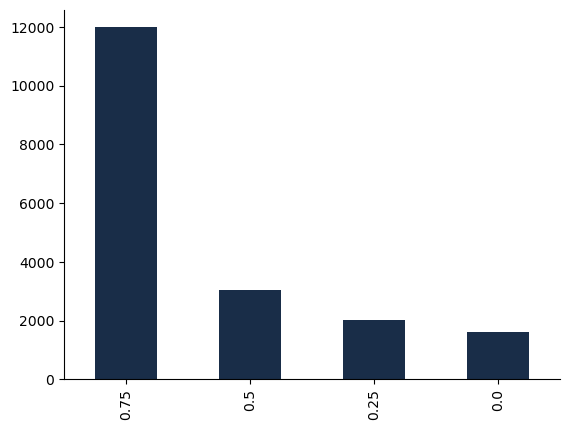

In [27]:
transcripts_df_filtered.query('admit=="Yes" and enroll=="Yes"').hseconstatus.value_counts().plot(kind='bar')

In [29]:
admitted_df.groupby('hsecon_tophalf')[features].describe()


cgpa_firstyear                                               \
                        count      mean       std  min  25%  50%  75%  max   
hsecon_tophalf                                                               
False                 11591.0  3.009585  0.732887  0.0  2.6  3.1  3.6  4.0   
True                   6316.0  2.796343  0.782601  0.0  2.3  2.9  3.4  4.0   

               testscore                                                  \
                   count         mean         std    min     25%     50%   
hsecon_tophalf                                                             
False            11989.0  1234.801068  125.907301  850.0  1150.0  1230.0   
True              6678.0  1170.616951  135.026225  850.0  1080.0  1170.0   

                                
                   75%     max  
hsecon_tophalf                  
False           1320.0  1580.0  
True            1260.0  1580.0

In [30]:
trueskill_dist_mean = admitted_df['cgpa_finalnotfirst'].mean()
trueskill_dist_var = admitted_df['cgpa_finalnotfirst'].var()

print("Mean of true skill: ", trueskill_dist_mean)
print("Variance of true skill: ", trueskill_dist_var)

Mean of true skill:  2.919343697081647
Variance of true skill:  0.5607727654453548


In [31]:
admitted_df.groupby('hsecon_tophalf')['cgpa_finalnotfirst'].mean()

hsecon_tophalf
False    2.984211
True     2.797639
Name: cgpa_finalnotfirst, dtype: float64

# Calibration exercise


Calibrate separately for each group. 

Assume each feature $\theta = q + N(\mu, \sigma^2)$.

Calibrate $\mu$ to be mean feature - mean q.
$\sigma^2$ is variance of the feature.

In [32]:
trueskill = 'cgpa_finalnotfirst'


In [33]:
# Filter out rows with missing values or 0s
admitted_df_regression = admitted_df.dropna(subset=features+[trueskill])
admitted_df_regression = admitted_df_regression.query('cgpa_finalnotfirst > 0')
admitted_df_regression = admitted_df_regression.query('testscore > 0')
admitted_df_regression = admitted_df_regression.query('cgpa_firstyear > 0')

admitted_df_regression['decileR'] = admitted_df_regression['decileR'].astype(float)
#admitted_df_regression = admitted_df_regression.query('decileR > 0')

admitted_df_regression = admitted_df_regression.reset_index(drop=True)

In [34]:
admitted_df_regression.groupby('hsecon_tophalf')[features].describe()

decileR                                               \
                  count      mean       std  min  25%  50%  75%  max   
hsecon_tophalf                                                         
False           10762.0  0.792576  0.123766  0.3  0.7  0.8  0.9  0.9   
True             5757.0  0.844693  0.090180  0.3  0.8  0.9  0.9  0.9   

               cgpa_firstyear            ...           testscore               \
                        count      mean  ...  75%  max     count         mean   
hsecon_tophalf                           ...                                    
False                 10762.0  3.066865  ...  3.6  4.0   10762.0  1238.661494   
True                   5757.0  2.884263  ...  3.4  4.0    5757.0  1175.497655   

                                                                   
                       std    min     25%     50%     75%     max  
hsecon_tophalf                                                     
False           125.885118  850.0  1150.0  1230.0  1320.0  1580.0  
True            134.942173  850.0  1080.0  1170.0  1260.0  1580.0  

[2 rows x 24 columns]

In [35]:
# NORMALIZE FEATURES
feature_coefs = {}
intercepts = {}
predicted_features = {}

for feature in features:
    model = LinearRegression()
    model.fit(np.array(admitted_df_regression['cgpa_finalnotfirst']).reshape(-1,1),
              np.array(admitted_df_regression[feature]))
    feature_coefs[feature] = model.coef_[0]
    intercepts[feature] = model.intercept_
    admitted_df_regression[f"{feature}_predicted"] = model.predict(np.array(admitted_df_regression['cgpa_finalnotfirst']).reshape(-1,1))



In [36]:
for feature in features:
    admitted_df_regression[f"{feature}_scaled"] = ((admitted_df_regression[feature] - intercepts[feature])
                                      /(feature_coefs[feature])
                                      )
    admitted_df_regression[f"{feature}_scaled_predicted"] = ((admitted_df_regression[f"{feature}_predicted"] - intercepts[feature])
                                                            /(feature_coefs[feature]))
    
    admitted_df_regression[f"{feature}_scaled_predicted_diff"] = (admitted_df_regression[f"{feature}_scaled_predicted"] - admitted_df_regression[f"{feature}_scaled"])

    
features_scaled = [feature+"_scaled" for feature in features]

Standard deviation  $\sigma_{gk}$ in paper

In [37]:

feature_dists = (admitted_df_regression
                 .groupby('hsecon_tophalf')[[f"{feature}_scaled_predicted_diff" for feature in features]]
                .agg(['mean', 'std'])
                .rename(columns=lambda x: x.replace('_scaled_predicted_diff', ''))
                .reindex([True, False])
                )

feature_dists

decileR           cgpa_firstyear           testscore  \
                    mean       std           mean       std      mean   
hsecon_tophalf                                                          
True           -0.896184  1.995161       0.084172  0.980212  0.910951   
False           0.479402  2.654410      -0.045027  0.913595 -0.487302   

                          
                     std  
hsecon_tophalf            
True            3.297434  
False           3.110763

# Set Parameters

In [38]:
"""
Can define costs arbitrarily or 
use matching costs from previous simulations (i.e., run only for costs for group B 
that correspond to a barrier level). 
"""


num_thresholds = 250
n_runs = 100

main_student_parameters = {
    "SIMULATION_TYPE": "SINGLE_SCHOOL_COST_MODEL" ,
   'NUM_STUDENTS' : 10000,
    "NUM_SCHOOL_TYPES": 1,
    "FRACTIONS_SCHOOL_TYPES": [1],
    "NUM_SCHOOLS": 1,
    'CAPACITY' : .1,
    #"NUM_FEATURES": len(features_to_use),
    "NUM_GROUPS": 2,
    "FRACTIONS_GROUPS": [0.5, 0.5],
     "FEATURE_DIST": ("NORMAL", 0, 1),
    'BINARY_SEARCH_NUM_THRESHOLDS': num_thresholds,
    'STUDENT_UTILITY': 5, 
}

cost_parameters = {
    'BINARY_SEARCH_NUM_THRESHOLDS': num_thresholds,
    'STUDENT_UTILITY': 5, 
}

In [39]:
# Try to read in existing matching cost dataframes if they exist
try:
    matching_cost_series_low = pd.read_csv(f"{simulation_data_info_path}/matching_cost_df_low.csv",
                                     index_col=0).squeeze() # Convert to series
    matching_cost_series_high = pd.read_csv(f"{simulation_data_info_path}/matching_cost_df_high.csv",
                                      index_col=0).squeeze() # Convert to series
    print("Successfully loaded existing matching cost series")
except FileNotFoundError:
    print("No existing matching cost series found")

Successfully loaded existing matching cost series


In [40]:
# Get number of unique values in combined matching cost dataframes
combined_values = np.concatenate([matching_cost_series_low.values, matching_cost_series_high.values])
print("Number of unique values in combined matching cost series:", len(np.unique(combined_values)))

Number of unique values in combined matching cost series: 41


In [42]:
# BARRIERS
barriers_A = 1
barriers_stepsize = 0.025
#barriers_stepsize = 0.2
barrier_Bs = np.arange(0, 1 + tolerance, barriers_stepsize).round(2)

barrier_Bs = np.append(barrier_Bs, [0.01, 0.02, 0.03, 0.04])
barrier_Bs = np.sort(barrier_Bs)
barrier_Bs

array([0.  , 0.01, 0.02, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1 , 0.12, 0.15,
       0.18, 0.2 , 0.22, 0.25, 0.28, 0.3 , 0.32, 0.35, 0.38, 0.4 , 0.43,
       0.45, 0.48, 0.5 , 0.52, 0.55, 0.58, 0.6 , 0.62, 0.65, 0.68, 0.7 ,
       0.73, 0.75, 0.78, 0.8 , 0.82, 0.85, 0.88, 0.9 , 0.92, 0.95, 0.98,
       1.  ])

In [41]:
# Two ways to define costs:
# 1. Use matching costs from previous simulations 
# (that induce the same test access level as a barrier level)
# 2. Define costs arbitrarily


tolerance = 0.01

costs = {}
costs["A"] = 0
cost_A = 0


# Use matching costs from previous simulations
cost_Bs = np.unique(combined_values).round(2)
cost_Bs.sort()

# # COSTS defined arbitrarily
# cost_stepsize = 0.05
# #cost_stepsize = 0.1
# utility = cost_parameters['STUDENT_UTILITY']

# cost_Bs = np.arange(costs["A"], utility+tolerance, cost_stepsize).round(2)

cost_Bs

array([0.  , 1.15, 1.35, 1.45, 1.55, 1.6 , 1.65, 1.75, 1.8 , 1.9 , 1.95,
       2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 ,
       2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05,
       3.1 , 3.15, 3.3 , 3.4 , 3.45, 3.55, 3.7 , 4.5 ])

In [43]:
parameters = {}
students_dfs_all = {}
params_dfs_all = {}
schools_dfs_all = {}

drop_schools_dfs_all = {}
drop_students_dfs_all = {}
drop_params_dfs_all = {}

## Parameters for different informativeness cases

### High informativeness case

Features = {First year GPA, test score}

In [44]:
features_to_use_high_info = ['cgpa_firstyear', 'testscore']

In [45]:
main_student_parameters_high_info = main_student_parameters.copy()

In [46]:
main_student_parameters_high_info["TRUESKILL_DIST"] = ("NORMAL", 
                                             0,
                                             np.round(trueskill_dist_var,3)
                                            )

main_student_parameters_high_info["NUM_FEATURES"] = len(features_to_use_high_info)

for i, feature in enumerate(features_to_use_high_info):
    main_student_parameters_high_info['FEATURE_DIST_A'+str(i)] = ("NORMAL", 
                                                        feature_dists[feature].loc[True, 'mean'].round(3),
                                                        (feature_dists[feature].loc[True, 'std']**2).round(3)
                                                       )
    main_student_parameters_high_info['FEATURE_DIST_B'+str(i)] = ("NORMAL", 
                                                        feature_dists[feature].loc[False, 'mean'].round(3),
                                                        (feature_dists[feature].loc[False, 'std']**2).round(3),
                                                       )

### Low informativeness case

In [47]:
features_to_use_low_info = ['decileR', 'testscore']

In [48]:
main_student_parameters_low_info = main_student_parameters.copy()
main_student_parameters_low_info["TRUESKILL_DIST"] = ("NORMAL", 
                                             0,
                                             np.round(trueskill_dist_var,3)
                                            )
main_student_parameters_low_info["NUM_FEATURES"] = len(features_to_use_low_info)

for i, feature in enumerate(features_to_use_low_info):
    main_student_parameters_low_info['FEATURE_DIST_A'+str(i)] = ("NORMAL", 
                                                        feature_dists[feature].loc[True, 'mean'].round(3),
                                                        (feature_dists[feature].loc[True, 'std']**2).round(3)
                                                       )
    main_student_parameters_low_info['FEATURE_DIST_B'+str(i)] = ("NORMAL", 
                                                        feature_dists[feature].loc[False, 'mean'].round(3),
                                                        (feature_dists[feature].loc[False, 'std']**2).round(3),
                                                       )


## Create list of instances to run

In [49]:

# COST INSTANCE
for i in range(n_runs):
    for cost_B in cost_Bs:
        # high info case
        instance_params_high_info = main_student_parameters_high_info.copy()
        instance_params_high_info["SIMULATION_TYPE"] = "SINGLE_SCHOOL_COST_MODEL"
        instance_params_high_info["STUDENT_TEST_COST"] = {"A": cost_A, "B":cost_B}
        instance_name = (f"costmodel_costB_{cost_B}_run_{i}")
        parameters["high_info_"+instance_name] = instance_params_high_info
        
        #low info case
        instance_params_low_info = main_student_parameters_low_info.copy()
        instance_params_low_info["SIMULATION_TYPE"] = "SINGLE_SCHOOL_COST_MODEL"
        instance_params_low_info["STUDENT_TEST_COST"] = {"A": cost_A, "B":cost_B}
        instance_name = (f"costmodel_costB_{cost_B}_run_{i}")
        parameters["low_info_"+instance_name] = instance_params_low_info


In [50]:


# BARRIER INSTANCE
for i in range(n_runs):
    for barrier_B in barrier_Bs:
        #high info case
        instance_params_high_info = main_student_parameters_high_info.copy()
        instance_params_high_info["SIMULATION_TYPE"] = "SINGLE_SCHOOL"
        
        instance_params_high_info.update({'PROB_MEETS_BUDGET_A':1, 
                                    'PROB_MEETS_BUDGET_B' : barrier_B,
                                    'DO_STUDENT_BUDGETS' : True})
        instance_name = (f"barriermodel__barrierB_{barrier_B}_run_{i}")
        parameters["high_info_"+instance_name] = instance_params_high_info
        
        #low info case
        instance_params_low_info = main_student_parameters_low_info.copy()
        instance_params_low_info["SIMULATION_TYPE"] = "SINGLE_SCHOOL"
        instance_params_low_info.update({'PROB_MEETS_BUDGET_A':1, 
                                    'PROB_MEETS_BUDGET_B' : barrier_B,
                                    'DO_STUDENT_BUDGETS' : True})
        instance_name = (f"barriermodel__barrierB_{barrier_B}_run_{i}")
        parameters["low_info_"+instance_name] = instance_params_low_info


In [51]:
parameters.keys()

dict_keys(['high_info_costmodel_costB_0.0_run_0', 'low_info_costmodel_costB_0.0_run_0', 'high_info_costmodel_costB_1.15_run_0', 'low_info_costmodel_costB_1.15_run_0', 'high_info_costmodel_costB_1.35_run_0', 'low_info_costmodel_costB_1.35_run_0', 'high_info_costmodel_costB_1.45_run_0', 'low_info_costmodel_costB_1.45_run_0', 'high_info_costmodel_costB_1.55_run_0', 'low_info_costmodel_costB_1.55_run_0', 'high_info_costmodel_costB_1.6_run_0', 'low_info_costmodel_costB_1.6_run_0', 'high_info_costmodel_costB_1.65_run_0', 'low_info_costmodel_costB_1.65_run_0', 'high_info_costmodel_costB_1.75_run_0', 'low_info_costmodel_costB_1.75_run_0', 'high_info_costmodel_costB_1.8_run_0', 'low_info_costmodel_costB_1.8_run_0', 'high_info_costmodel_costB_1.9_run_0', 'low_info_costmodel_costB_1.9_run_0', 'high_info_costmodel_costB_1.95_run_0', 'low_info_costmodel_costB_1.95_run_0', 'high_info_costmodel_costB_2.0_run_0', 'low_info_costmodel_costB_2.0_run_0', 'high_info_costmodel_costB_2.05_run_0', 'low_info_c

In [52]:
len(parameters.keys())

17000

# Run sims

In [53]:
instances_done = [f.name for f in os.scandir(simulation_data_path) if f.is_dir()]
if '.ipynb_checkpoints' in instances_done: instances_done.remove('.ipynb_checkpoints')
len(instances_done)

18200

In [55]:
num_instances_to_run = len(set(list(parameters.keys())) - set(instances_done))
num_instances_to_run

0

In [56]:
# progress bar
f = IntProgress(min=0, max=num_instances_to_run)
display(f)

for instance in parameters.keys():
    if instance not in instances_done:
        #print(instance)
            
        instance_folder = simulation_data_path+instance
        
        #costs = parameters[instance]["STUDENT_TEST_COST"]
        
        students_df, schools_df, params_df = pipeline.pipeline(parameters[instance])
        
        # #define coarse skillcut
        # roundmult=5
        # students_df.loc[:, "skillcut_coarse"] = (students_df.skill.rank(pct=True) * roundmult).round(1) / roundmult
        
        students_dfs_all[instance] = students_df
        schools_dfs_all[instance] = schools_df
        params_df = pd.Series(params_df)
        params_dfs_all[instance] = params_df
        
        
        params_no_test = parameters[instance].copy()
        params_no_test["SIMULATION_TYPE"] = "SINGLE_SCHOOL"
        params_no_test['FEATURES_TO_USE_a'] = -1

        drop_students_df, drop_schools_df, drop_params_df = pipeline.pipeline(params_no_test)
        drop_params_df = pd.Series(drop_params_df)
        
        drop_students_dfs_all[instance] = drop_students_df
        drop_schools_dfs_all[instance] = drop_schools_df
        drop_params_dfs_all[instance] = drop_params_df
        
        os.makedirs(instance_folder, exist_ok=True)
        df_cost_names = ['students_df', 'schools_df', 'params_df']
        df_no_test_names = ['drop_students_df', 'drop_schools_df', 'drop_params_df']
        for df_name in df_cost_names:
            #print(df_name)
            #for cost in costs:
            globals()[df_name].to_csv("{}/{}.csv".format(instance_folder, df_name))
        for df_name in df_no_test_names:
            globals()[df_name].to_csv("{}/{}.csv".format(instance_folder, df_name))
            
        f.value += 1


IntProgress(value=0, max=0)

# Read in data for simulations run

In [57]:
instances_done = [f.name for f in os.scandir(simulation_data_path) if f.is_dir()]
if '.ipynb_checkpoints' in instances_done: instances_done.remove('.ipynb_checkpoints')
len(instances_done)

18200

In [58]:
columns_to_convert = ['admitted_students',
                      'prob_apply_rawskill_A', 'avgadmittedtestscore_B', 'prob_apply_test_B',
                    'prob_apply_rawtest_A', 'prob_apply_rawtest_B', 
                      'prob_apply_rawskill_B', 'prob_apply_test_A',
                    'prob_apply_skill_A', 'avgadmittedskill', 'IF', 'IF_rawskill',
                    'prob_apply_skill_B',]

In [59]:
dict_columns = ['IF', 'IF_rawskill']


In [60]:
defaultdict_columns = ['prob_apply_rawskill_A', 'prob_apply_test_B',
'prob_apply_rawtest_A', 'prob_apply_rawtest_B', 'prob_apply_rawskill_B', 'prob_apply_test_A',
'prob_apply_skill_A', 
'prob_apply_skill_B']

converters = {col: literal_converter for col in dict_columns}
converters.update({col: defaultdict_converter for col in defaultdict_columns})
converters['admitted_students'] = literal_converter

In [61]:
def read_csv_with_default(file_path, usecols, converters,
                          default_value=0):
    try:
        # Attempt to read the specified columns
        df = pd.read_csv(file_path, usecols=usecols, converters=converters)
    except ValueError as e:
        # If columns are missing, create a DataFrame with default values
        missing_cols = [col for col in usecols if col not in pd.read_csv(file_path, nrows=0).columns]
        df = pd.read_csv(file_path)
        for col in missing_cols:
            df[col] = default_value
        df = df[usecols]  # Reorder columns to match usecols
    return df

In [62]:
students_dfs_all = defaultdict(dict)
schools_dfs_all = defaultdict(dict)
params_dfs_all = defaultdict(dict)

drop_students_dfs_all = defaultdict(dict)
drop_schools_dfs_all = defaultdict(dict)
drop_params_dfs_all = defaultdict(dict)


columns_to_read_cost = {
    'schools_df': ['frac_A',
                    'frac_B',
                    'avgadmittedskill_A',
                    'avgadmittedskill_B',
                    'avgadmittedskill',],  
    'students_df': ['group','skill', 'admitted',
                    'take_test_at_threshold']  
}

columns_to_read_barrier = {
    'schools_df': ['frac_A',
                    'frac_B',
                    'avgadmittedskill_A',
                    'avgadmittedskill_B',
                    'avgadmittedskill',],  
    'students_df': ['group','skill', 'admitted'
                    ]  
}


#costs_all = {}
#cost_Bs = {}

for instance in instances_done:
    directory_path = simulation_data_path+instance
    # Extract the cost value and data type from the filename
    cost_pattern = r'([^_]+)_info_costmodel_costB_([^_]+)_run_([^_]+)$'
    barrier_pattern = r'([^_]+)_info_barriermodel__barrierB_([^_]+)_run_([^_]+)$'
    # Match the filename pattern
    cost_match = re.search(cost_pattern, instance)
    barrier_match = re.search(barrier_pattern, instance)
    if cost_match:
        info_type = cost_match.group(1)
        cost_B = cost_match.group(2)
    elif barrier_match:
        info_type = barrier_match.group(1)


    for file_type in [#'params_df', 
                      'schools_df', 'students_df']:
        file_path = os.path.join(directory_path, file_type)+".csv"
        if cost_match:
            df = read_csv_with_default(file_path, 
                             #index_col=0, 
                            converters=converters,
                            usecols=columns_to_read_cost[file_type]
                            )
        elif barrier_match:
            df = read_csv_with_default(file_path, 
                             #index_col=0, 
                            converters=converters,
                            usecols=columns_to_read_barrier[file_type]
                            )
        if file_type == 'students_df': #define coarse skillcut
            # bucket students into skill bins
            roundmult=5
            df.loc[:, "skillcut_coarse"] = (df.skill.rank(pct=True) * roundmult).round(1) / roundmult

            
        globals()[file_type+"s_all"][instance] = df

    
    drop_params_dfs_all[info_type][instance] = (pd.read_csv(directory_path+"/drop_params_df.csv", 
                                                index_col=0,
                                                converters={'0': literal_converter}
                                               )
                                    )
    drop_students_dfs_all[info_type][instance] = pd.read_csv(directory_path+"/drop_students_df.csv", 
                                                  index_col=0)
    drop_schools_dfs_all[info_type][instance] = pd.read_csv(directory_path+"/drop_schools_df.csv", 
                                                 converters=converters,
                                                 index_col=0)
        
        

### Example on how to subset

In [65]:
B1 = 2.9
costB = 3.0

instance_subset = [instance for instance in instances_done 
                     if "B1_2.9" in instance and "costB_3.0" in instance ]

In [66]:
cost_Bs

array([0.  , 1.15, 1.35, 1.45, 1.55, 1.6 , 1.65, 1.75, 1.8 , 1.9 , 1.95,
       2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 ,
       2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05,
       3.1 , 3.15, 3.3 , 3.4 , 3.45, 3.55, 3.7 , 4.5 ])

In [67]:
costs_subset = cost_Bs


### Calculate metrics

In [68]:
metrics = ['frac_A', 'frac_B',
           #'avgadmittedtestscore_A', 'avgadmittedtestscore_B', 
           'avgadmittedskill_A', 'avgadmittedskill_B', 
          'avgadmittedskill']
metrics_B = ['frac_B', 'avgadmittedskill_B']

In [69]:
instances_subset = list(parameters.keys())
instances_subset = instances_done


In [70]:
barrier_instances = [instance for instance in instances_done 
                    if "barrier" in instance]
cost_instances = [instance for instance in instances_done 
                    if "cost" in instance]

In [72]:
metrics = ['frac_A',
 'frac_B',
 'avgadmittedskill_A',
 'avgadmittedskill_B',
 'avgadmittedskill',
 'p_apply_',
 'if_gap']

In [78]:
metrics_df_cost = defaultdict(dict)
for info_type in ["high", "low"]:
    metrics_df_cost[info_type]["p_apply_A"] = defaultdict(dict)
    metrics_df_cost[info_type]["p_apply_B"] = defaultdict(dict)
    for metric in metrics:
        print(metric)
        metrics_df_cost[info_type][metric] = defaultdict(dict)
        
        for cost in costs_subset:
            for i in range(n_runs):
                b1_cost_instance = f'{info_type}_info_costmodel_costB_{cost}_run_{i}'
                #print(b1_cost_instance)
                if metric == 'p_apply_':
                    for group in ["A", "B"]:
                        student_df = students_dfs_all[b1_cost_instance].query('group==@group')
                        p_apply_group = student_df['take_test_at_threshold'].mean()
                        metrics_df_cost[info_type][metric+group][cost][i] = p_apply_group
                elif metric == 'if_gap':
                    student_df = students_dfs_all[b1_cost_instance]
                    if_gap = (student_df.query('group=="A"').groupby('skillcut_coarse')['admitted'].mean()
                            - student_df.query('group=="B"').groupby('skillcut_coarse')['admitted'].mean())
                    
                    metrics_df_cost[info_type][metric][cost][i] = if_gap
                    
                    # for group in ["A", "B"]:
                    # student_df = students_dfs_all[b1_cost_instance].query('group==@group')
                    #pass
                else:
                    if (metric in metrics_B 
                        and len(students_dfs_all[b1_cost_instance].query('group=="B" and take_test_at_threshold==True'))==0):
                        metrics_df_cost[info_type][metric][cost][i] = 0
                        #print("TRUE")
                    else:
                        #print("FALSE")
                        metrics_df_cost[info_type][metric][cost][i] = schools_dfs_all[b1_cost_instance][metric][0]

        metrics_df_cost[info_type][metric] = pd.DataFrame(metrics_df_cost[info_type][metric]).sort_index(axis=1)#.dropna('columns')
    metrics_df_cost[info_type]["p_apply_A"] = pd.DataFrame(metrics_df_cost[info_type]["p_apply_A"]).sort_index(axis=1)
    metrics_df_cost[info_type]["p_apply_B"] = pd.DataFrame(metrics_df_cost[info_type]["p_apply_B"]).sort_index(axis=1)
    


frac_A
frac_B
avgadmittedskill_A
avgadmittedskill_B
avgadmittedskill
p_apply_
if_gap
frac_A
frac_B
avgadmittedskill_A
avgadmittedskill_B
avgadmittedskill
p_apply_
if_gap


In [79]:

metrics_df_barrier = defaultdict(dict)

for info_type in ["high", "low"]:
    metrics_df_barrier[info_type]['p_apply'] = defaultdict(dict)
    #metrics_df_barrier[info_type]['p_admit_given_top10'] = {}

    for metric in metrics:
        print(metric)
        metrics_df_barrier[info_type][metric] = defaultdict(dict)
        if metric == 'p_apply_':
            metrics_df_barrier[info_type]["p_apply_A"] = barriers_A
            metrics_df_barrier[info_type]["p_apply_B"] = pd.Series({barrier: barrier for barrier in barrier_Bs})

        else:
            for barrier in barrier_Bs:
                for i in range(n_runs):
                    b1_barrier_instance = f'{info_type}_info_barriermodel__barrierB_{barrier}_run_{i}'
                
                    if metric == 'if_gap':
                        student_df = students_dfs_all[b1_barrier_instance]
                        if_gap = (student_df.query('group=="A"').groupby('skillcut_coarse')['admitted'].mean()
                            - student_df.query('group=="B"').groupby('skillcut_coarse')['admitted'].mean())
                        # if_gap = pd.Series(schools_dfs_all[b1_barrier_instance]["IF_rawskill"][0]).sort_index()
                        metrics_df_barrier[info_type][metric][barrier][i] = if_gap
                    else:
                        if (metric in metrics_B 
                            and len(students_dfs_all[b1_barrier_instance].query('group=="B" and admitted==True'))==0):
                            metrics_df_barrier[info_type][metric][barrier][i] = 0
                        else:
                            metrics_df_barrier[info_type][metric][barrier][i] = schools_dfs_all[b1_barrier_instance][metric][0]

                    metrics_df_barrier[info_type]['p_apply'][barrier][i] = barrier

            metrics_df_barrier[info_type][metric] = pd.DataFrame(metrics_df_barrier[info_type][metric]).sort_index(axis=1)

    metrics_df_barrier[info_type]['p_apply'] = pd.DataFrame(metrics_df_barrier[info_type]['p_apply']).sort_index(axis=1)

    

frac_A
frac_B
avgadmittedskill_A
avgadmittedskill_B
avgadmittedskill
p_apply_
if_gap
frac_A
frac_B
avgadmittedskill_A
avgadmittedskill_B
avgadmittedskill
p_apply_
if_gap


# Match on P(take test)

For each P(take test) in the barrier model, find the cost level that matches the P(take test) in the strategic students model.

Saves the matching cost for later use.

In [80]:
matching_cost_df= defaultdict(dict)

for info_type in ["high", "low"]:
    for access_value in metrics_df_barrier[info_type]['p_apply_B'].index:

        cost_column = metrics_df_cost[info_type]['p_apply_B'].mean(axis=0)
        cost_column.index = cost_column.index.astype(float)
        absolute_diff = np.abs(access_value - cost_column)
        min_index = absolute_diff.idxmin()
        matching_cost_df[info_type][float(access_value)] = min_index
    matching_cost_df[info_type] = pd.Series(matching_cost_df[info_type]).astype(float)
    matching_cost_df[info_type].to_csv(f"{simulation_data_info_path}/matching_cost_df_{info_type}.csv")

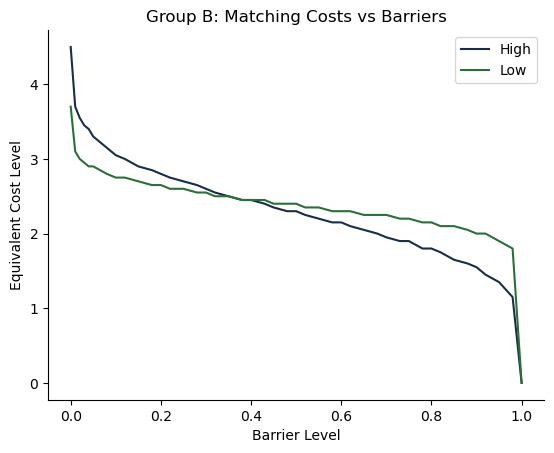

In [98]:
matching_cost_df["high"].plot(label="High")
matching_cost_df["low"].plot(label="Low")
plt.legend()


plt.title("Group B: Matching Costs vs Barriers")
plt.xlabel("Barrier Level") 
plt.ylabel("Equivalent Cost Level")

plt.savefig(f"{figure_data_path}/matching_cost_vs_barrier.png", dpi=300)

In [82]:
matched_test_df = defaultdict(dict)
for info_type in ["high", "low"]:
    for metric in ['avgadmittedskill_A', 'avgadmittedskill_B','avgadmittedskill',
                   'frac_B', 'if_gap']:

        matched_test_df[info_type][metric] = {barrier: metrics_df_cost[info_type][metric][matching_cost_df[info_type].loc[barrier]]
                                    for barrier in matching_cost_df[info_type].index}
        matched_test_df[info_type][metric] = pd.DataFrame(matched_test_df[info_type][metric])

# Visualizations

In [83]:
colormap = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [118]:
metric_name_map = {'frac_B':"$\\tau$, Diversity level", 
                   'avgadmittedskill':"Avg admitted skill", 
                #    'p_admit_given_top10_A':"P(Admitted | Top 10%, Group $A$)", 
                #    'p_admit_given_top10_B':"P(Admitted | Top 10%, Group $B$)",
                  'avgadmittedskill_A':"Avg admitted skill, Group $A$",
                  'avgadmittedskill_B':"Avg admitted skill, Group $B$",
                  'if_gap':"Individual fairness gap",
                  }

## High Informativeness Case

In [196]:
info_type = "high"

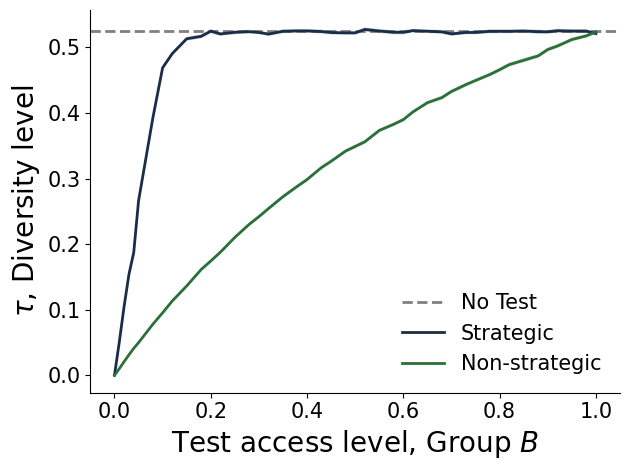

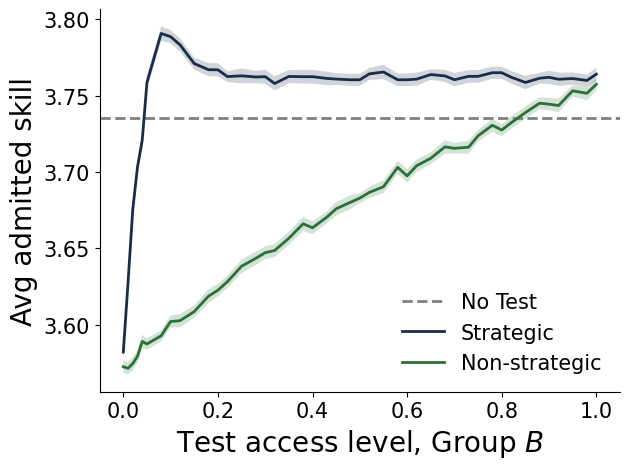

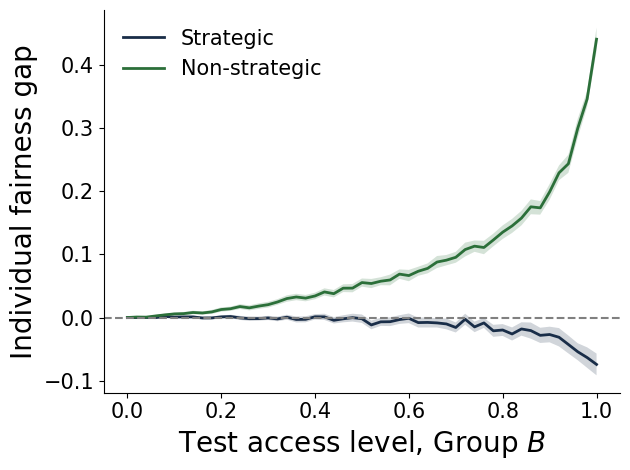

In [197]:
window = 3
metrics_to_plot = ['frac_B', 'avgadmittedskill', 
                  ]

trueskill_window = 10
ci_width = 2


for i, metric in enumerate(metrics_to_plot):
    plt.figure()
    add_mean = 0
    # if metric is avgadmittedskill, add the trueskill mean
    if metric == 'avgadmittedskill': 
        add_mean = trueskill_dist_mean
        
    no_test_series = pd.Series({instance: drop_schools_dfs_all[info_type][instance][metric][0] 
                             for instance in instances_subset if info_type in instance})
    plt.axhline(no_test_series.mean() + add_mean, 
                label="No Test", 
                linestyle='dashed', linewidth=2, color='grey')
    

    ((matched_test_df[info_type][metric]
     .mean() + add_mean)
     .plot( label="Strategic", linewidth=2)
     )
    se_cost = matched_test_df[info_type][metric].std() / (np.sqrt(len(matched_test_df[info_type][metric])))
    plt.fill_between(matched_test_df[info_type][metric].columns, 
                     matched_test_df[info_type][metric].mean() + add_mean - se_cost*ci_width, 
                     matched_test_df[info_type][metric].mean() + add_mean + se_cost*ci_width, 
                     alpha=0.2)
    
    ((metrics_df_barrier[info_type][metric]
     .mean() + add_mean)
     .plot( label="Non-strategic", linewidth=2))
    se_barrier = metrics_df_barrier[info_type][metric].std() / (np.sqrt(len(metrics_df_barrier[info_type][metric])))
    plt.fill_between(metrics_df_barrier[info_type][metric].columns, 
                     metrics_df_barrier[info_type][metric].mean() + add_mean - se_barrier*ci_width, 
                     metrics_df_barrier[info_type][metric].mean() + add_mean + se_barrier*ci_width, 
                     alpha=0.2)
    
    plt.ylabel(metric_name_map[metric], fontsize=20)
    plt.xlabel("Test access level, Group $B$", fontsize=20)
    plt.legend(#loc=(1.1,0.1), 
               frameon=False, fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.tight_layout()
    
    plt.savefig(f"{figure_data_path}/{info_type}_info_{metric}_compare_barrier_cost_notest.png", dpi=300)
   
    
access_value = 0.4

metric = 'if_gap'
plt.figure()
matched_if_gap_cost = pd.DataFrame({i: matched_test_df[info_type][metric][access_value][i] for i in range(n_runs)}).T
matched_if_gap_barrier = pd.DataFrame({i: metrics_df_barrier[info_type][metric][access_value][i] for i in range(n_runs)}).T
(matched_if_gap_cost.mean()
 #.rolling(window).mean()
 .plot( label="Strategic", linewidth=2)
 )
(matched_if_gap_barrier.mean()
 #.rolling(trueskill_window).mean()
 .plot( label="Non-strategic", linewidth=2)
 )
se_cost = matched_if_gap_cost.std() / (np.sqrt(len(matched_if_gap_cost)))
plt.fill_between(matched_if_gap_cost.columns, 
                 matched_if_gap_cost.mean() - se_cost*ci_width, 
                 matched_if_gap_cost.mean() + se_cost*ci_width, 
                 alpha=0.2)
se_barrier = matched_if_gap_barrier.std() / (np.sqrt(len(matched_if_gap_barrier)))
plt.fill_between(matched_if_gap_barrier.columns, 
                 matched_if_gap_barrier.mean() - se_barrier*ci_width, 
                 matched_if_gap_barrier.mean() + se_barrier*ci_width, 
                 alpha=0.2)

plt.axhline(0, linestyle='dashed', color='grey')
plt.ylabel(metric_name_map[metric], fontsize=20)
#plt.legend(loc=(1.1,0.1))
plt.xlabel("Test access level, Group $B$", fontsize=20)

plt.legend(#loc=(1.1,0.1), 
            frameon=False, fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.tight_layout()

plt.savefig(f"{figure_data_path}/{info_type}_info_{metric}_compare_barrier_cost_notest.png", dpi=300)


## Low Informativeness Case

In [201]:
info_type = "low"

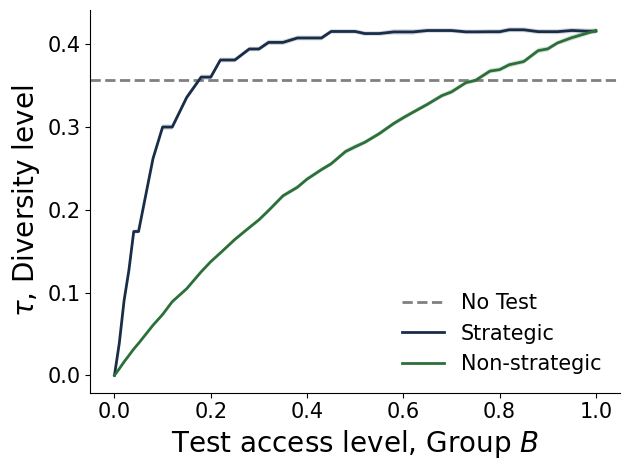

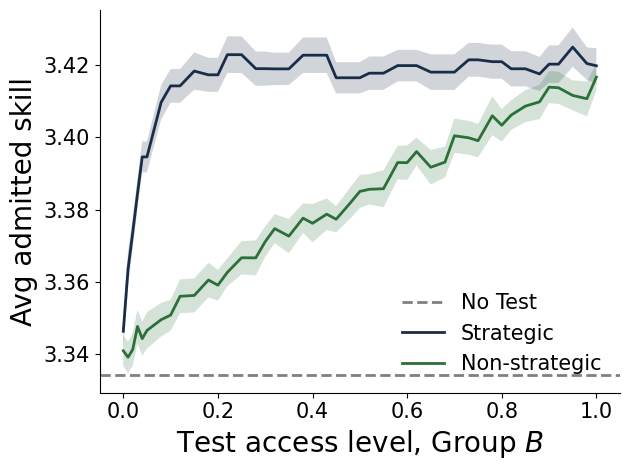

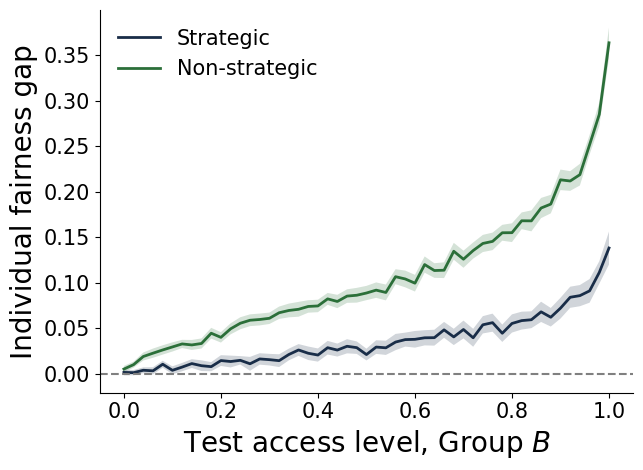

In [202]:
window = 3
metrics_to_plot = ['frac_B', 'avgadmittedskill', 
                  ]

trueskill_window = 10
ci_width = 2


for i, metric in enumerate(metrics_to_plot):
    plt.figure()
    add_mean = 0
    # if metric is avgadmittedskill, add the trueskill mean
    if metric == 'avgadmittedskill': 
        add_mean = trueskill_dist_mean
        #add_mean=0
        
    no_test_series = pd.Series({instance: drop_schools_dfs_all[info_type][instance][metric][0] 
                             for instance in instances_subset if info_type in instance})
    plt.axhline(no_test_series.mean() + add_mean, 
                label="No Test", 
                linestyle='dashed', linewidth=2, color='grey')
    

    ((matched_test_df[info_type][metric]
     .mean() + add_mean)
     .plot( label="Strategic", linewidth=2)
     )
    se_cost = matched_test_df[info_type][metric].std() / (np.sqrt(len(matched_test_df[info_type][metric])))
    plt.fill_between(matched_test_df[info_type][metric].columns, 
                     matched_test_df[info_type][metric].mean() + add_mean - se_cost*ci_width, 
                     matched_test_df[info_type][metric].mean() + add_mean + se_cost*ci_width, 
                     alpha=0.2)
    
    ((metrics_df_barrier[info_type][metric]
     .mean() + add_mean)
     .plot( label="Non-strategic", linewidth=2))
    se_barrier = metrics_df_barrier[info_type][metric].std() / (np.sqrt(len(metrics_df_barrier[info_type][metric])))
    plt.fill_between(metrics_df_barrier[info_type][metric].columns, 
                     metrics_df_barrier[info_type][metric].mean() + add_mean - se_barrier*ci_width, 
                     metrics_df_barrier[info_type][metric].mean() + add_mean + se_barrier*ci_width, 
                     alpha=0.2)
    
    plt.ylabel(metric_name_map[metric], fontsize=20)
    plt.xlabel("Test access level, Group $B$", fontsize=20)
    plt.legend(#loc=(1.1,0.1), 
               frameon=False, fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.tight_layout()
    
    plt.savefig(f"{figure_data_path}/{info_type}_info_{metric}_compare_barrier_cost_notest.png", dpi=300)
   
    
access_value = 0.4

metric = 'if_gap'
plt.figure()
matched_if_gap_cost = pd.DataFrame({i: matched_test_df[info_type][metric][access_value][i] for i in range(n_runs)}).T
matched_if_gap_barrier = pd.DataFrame({i: metrics_df_barrier[info_type][metric][access_value][i] for i in range(n_runs)}).T
(matched_if_gap_cost.mean()
 #.rolling(window).mean()
 .plot( label="Strategic", linewidth=2)
 )
(matched_if_gap_barrier.mean()
 #.rolling(trueskill_window).mean()
 .plot( label="Non-strategic", linewidth=2)
 )
se_cost = matched_if_gap_cost.std() / (np.sqrt(len(matched_if_gap_cost)))
plt.fill_between(matched_if_gap_cost.columns, 
                 matched_if_gap_cost.mean() - se_cost*ci_width, 
                 matched_if_gap_cost.mean() + se_cost*ci_width, 
                 alpha=0.2)
se_barrier = matched_if_gap_barrier.std() / (np.sqrt(len(matched_if_gap_barrier)))
plt.fill_between(matched_if_gap_barrier.columns, 
                 matched_if_gap_barrier.mean() - se_barrier*ci_width, 
                 matched_if_gap_barrier.mean() + se_barrier*ci_width, 
                 alpha=0.2)

plt.axhline(0, linestyle='dashed', color='grey')
plt.ylabel(metric_name_map[metric], fontsize=20)
#plt.legend(loc=(1.1,0.1))
plt.xlabel("Test access level, Group $B$", fontsize=20)

plt.legend(#loc=(1.1,0.1), 
            frameon=False, fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.tight_layout()

plt.savefig(f"{figure_data_path}/{info_type}_info_{metric}_compare_barrier_cost_notest.png", dpi=300)
#plt.savefig(figure_data_path+metric+"compare_barrier_cost_notest.png", dpi=300)


# Tables

In [203]:
ci_width = 2

test_access_level = 0.4

summary_stats_mean = defaultdict(dict)
summary_stats_ci_width = defaultdict(dict)

for info_type in ["low", "high"]:
    for metric in ["avgadmittedskill", "frac_B"]:
        summary_stats_mean[info_type][metric] = {}
        summary_stats_ci_width[info_type][metric] = {}
        if metric == "avgadmittedskill": add_mean = trueskill_dist_mean
        else: add_mean = 0
        no_test_series = pd.Series({instance: drop_schools_dfs_all[info_type][instance][metric][0] 
                            for instance in instances_subset if info_type in instance})
        summary_stats_mean[info_type][metric]["no_test"] = no_test_series.mean() + add_mean
        summary_stats_ci_width[info_type][metric]["no_test"] = ci_width*no_test_series.std() / (np.sqrt(len(no_test_series)))
        
        cost_mean = (matched_test_df[info_type][metric].mean() + add_mean)
        cost_se = matched_test_df[info_type][metric].std() / (np.sqrt(len(matched_test_df[info_type][metric])))
        summary_stats_mean[info_type][metric]["strategic_with_test"] = cost_mean[test_access_level]
        summary_stats_ci_width[info_type][metric]["strategic_with_test"] = ci_width*cost_se[test_access_level]
        
        barrier_mean = (metrics_df_barrier[info_type][metric].mean() + add_mean)
        barrier_se = (metrics_df_barrier[info_type][metric].std() / (np.sqrt(len(metrics_df_barrier[info_type][metric]))))
        summary_stats_mean[info_type][metric]["nonstrategic_with_test"] = barrier_mean[test_access_level]
        summary_stats_ci_width[info_type][metric]["nonstrategic_with_test"] = ci_width*barrier_se[test_access_level]
        



In [204]:
summary_stats_mean_df = pd.DataFrame.from_dict(
    {(info_type, metric): summary_stats_mean[info_type][metric] 
     for info_type in summary_stats_mean.keys() 
     for metric in summary_stats_mean[info_type].keys()},
    orient='index'
)

summary_stats_ci_width_df = pd.DataFrame.from_dict(
    {(info_type, metric): summary_stats_ci_width[info_type][metric] 
     for info_type in summary_stats_ci_width.keys() 
     for metric in summary_stats_ci_width[info_type].keys()},
    orient='index'
)

In [205]:
summary_stats_mean_df

no_test  strategic_with_test  nonstrategic_with_test
low  avgadmittedskill  3.334135             3.422722                3.376209
     frac_B            0.356606             0.407667                0.237100
high avgadmittedskill  3.735313             3.762351                3.663469
     frac_B            0.524255             0.525061                0.298450

In [206]:
summary_stats_ci_width_df

no_test  strategic_with_test  nonstrategic_with_test
low  avgadmittedskill  0.000484             0.004912                0.005286
     frac_B            0.000306             0.002902                0.002552
high avgadmittedskill  0.000432             0.004504                0.004267
     frac_B            0.000313             0.003032                0.003049